In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import optim, nn

In [4]:
train_targets = pd.read_csv('train.csv')

In [5]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [6]:
stock_id = stock_ids[19]

In [7]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

In [8]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2

In [9]:
collect_data = []
for time_id, time_id_data in book.groupby('time_id'):
    time_id_data['time_id'] = time_id
    time_id_data = pd.merge(time_id_data, pd.DataFrame({'seconds_in_bucket': range(0, 600)}), 
                           on='seconds_in_bucket', how='right')

    collect_data.append(time_id_data.sort_values('seconds_in_bucket').ffill().bfill())

/home/dro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
X = torch.tensor([x.iloc[:, 2:].values[np.newaxis, :, :] for x in collect_data], dtype=torch.float32)
y = torch.tensor(train_targets[train_targets.stock_id == stock_id]['target'].values)

In [11]:
model = nn.Sequential(nn.Conv2d(1, 4, kernel_size=(4, 4)), 
                      nn.ReLU(), 
                     nn.Conv2d(4, 8, kernel_size=(4, 4)), 
                      nn.ReLU(),
                     nn.Conv2d(8, 16, kernel_size=(4, 1)),
                     nn.Flatten(),
                     nn.Sigmoid(),
                     nn.Linear(56736, 1))

In [12]:
n_objects = X.shape[0]

train_inds = np.random.choice(range(n_objects), replace=False, size=int(0.75*n_objects))
test_inds = np.delete(range(n_objects), train_inds)

X_train = X[train_inds]
X_test = X[test_inds]

y_train = y[train_inds]
y_test = y[test_inds]

In [13]:
def my_loss(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [14]:
opt = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
batch_size = 64
n_step = 10000

In [16]:
loss_history = []

In [17]:
for n in trange(n_step):
    batch_inds = np.random.choice(range(X_train.shape[0]), replace=False, size=batch_size)
    X_batch = X_train[batch_inds]
    y_batch = y_train[batch_inds]
    
    y_pred = model(X_batch)[:, 0]
    
    loss = my_loss(y_batch, y_pred)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    loss_history.append(loss.detach().numpy())
    
    

100%|██████████| 10000/10000 [22:47<00:00,  7.31it/s]


In [18]:
loss_history[100]

array(10.35831109)

In [19]:
loss = my_loss(y_train, 0.9*model(X_train)[:, 0])
loss

tensor(0.4050, dtype=torch.float64, grad_fn=<SqrtBackward>)

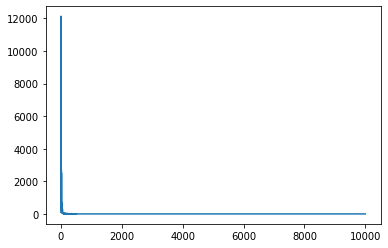

In [20]:
plt.plot(loss_history)